<a href="https://colab.research.google.com/github/hinatanvir/Fault-Detection-SECOM/blob/main/Fault_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import pandas as pd
import statistics
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import statistics as stat
from scipy.stats import binom
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle
# splitting merge_data into train test and split
from sklearn.model_selection import train_test_split, cross_validate
from scipy import stats
from scipy.stats import normaltest
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib as mpl
import warnings; warnings.filterwarnings(action='once')
# to keep track of training time
import datetime
# logistic regression model
from sklearn.linear_model import LogisticRegression
# metrics used for evaluation
from sklearn.metrics import f1_score, matthews_corrcoef
# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
from sklearn.metrics import plot_roc_curve
# KNN imputation
from sklearn.impute import KNNImputer
# normalizer
from sklearn.preprocessing import Normalizer
# variance threshold
from sklearn.feature_selection import VarianceThreshold
# RFECV
from sklearn.model_selection import StratifiedKFold
# random forest
from sklearn.ensemble import RandomForestClassifier
# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer
from scipy import stats 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split 
from sklearn.model_selection import cross_val_score # Evaluate a score by cross-validation
from sklearn.model_selection import GridSearchCV # Exhaustive search over specified parameter values for an estimator
from sklearn.metrics import classification_report # Build a text report showing the main classification metrics
from sklearn.metrics import accuracy_score # Accuracy classification score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # to show confusion matrix
from sklearn import metrics # Evaluate ROC curve
from sklearn.experimental import enable_iterative_imputer # Enables IterativeImputer. The API and results of this estimator might change without any deprecation cycle
from sklearn.impute import IterativeImputer
from imblearn.combine import SMOTEENN # Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours
from sklearn import decomposition
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap




# Read Files

In [115]:
def read_secom():
    path ='C:/Users/duygu/OneDrive/Documents/VS_CODE_REPOS/Fault-Detection-SECOM/secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature'+str(x+1) for x in range(len(df.columns))]
    return df

#%%
def read_labels():
    path = 'C:/Users/duygu/OneDrive/Documents/VS_CODE_REPOS/Fault-Detection-SECOM/secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#read 2 df 
df_features = read_secom()
df_target = read_labels()

In [116]:
df_features.columns = ['feature'+str(x+1) for x in range(len(df_features.columns))]

In [117]:
df_target.columns=['status','timestamp']

# Merge Data

In [118]:
#converting timestamp to datetime format, dayfirst=True arg ensures days and month dont switch 
#for dates lesser than 13 
df_target['timestamp']=pd.to_datetime(df_target['timestamp'],dayfirst=True)

In [119]:
#check format of dates for lesser than 13 
mask = (df_target['timestamp'] > '2008-08-11 00:00:00') & (df_target['timestamp'] <= '2008-08-16 00:00:00')
filtered_df=df_target.loc[mask]
print(filtered_df)

     status           timestamp
190      -1 2008-08-11 03:06:00
191      -1 2008-08-11 04:09:00
192      -1 2008-08-11 05:15:00
193      -1 2008-08-11 11:35:00
194      -1 2008-08-11 12:38:00
195      -1 2008-08-12 04:23:00
196      -1 2008-08-12 06:16:00
197      -1 2008-08-12 10:54:00
198      -1 2008-08-12 11:29:00
199      -1 2008-08-12 12:04:00
200      -1 2008-08-13 02:48:00
201      -1 2008-08-15 03:26:00
202      -1 2008-08-15 04:14:00
203      -1 2008-08-15 05:13:00
204      -1 2008-08-15 09:38:00
205      -1 2008-08-15 10:14:00
206      -1 2008-08-15 11:42:00
207      -1 2008-08-15 18:19:00
208      -1 2008-08-15 19:19:00
209      -1 2008-08-15 20:00:00
210      -1 2008-08-15 20:03:00
211      -1 2008-08-15 23:31:00


In [120]:
df= pd.concat([df_features,df_target],axis=1)
df

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,status,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 15:22:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1,2008-10-16 15:13:00
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1,2008-10-16 20:49:00
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1,2008-10-17 05:26:00
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1,2008-10-17 06:01:00


# Frequency distribution of target values

<AxesSubplot:>

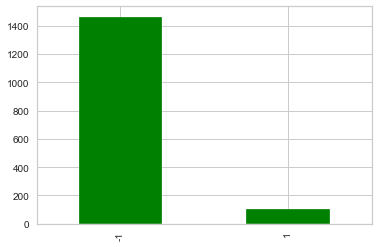

In [121]:
#frequency distribution of target values
df.status.value_counts().plot(kind = 'bar',color='green')

In [122]:


df_data = read_secom()
df_label = read_labels()
df = pd.concat([df_data,df_label],axis=1)
print(df.head())
# %%
#goal: go through each columns for their stats


   feature1  feature2   feature3   feature4  feature5  feature6  feature7  \
0   3030.93   2564.00  2187.7333  1411.1265    1.3602     100.0   97.6133   
1   3095.78   2465.14  2230.4222  1463.6606    0.8294     100.0  102.3433   
2   2932.61   2559.94  2186.4111  1698.0172    1.5102     100.0   95.4878   
3   2988.72   2479.90  2199.0333   909.7926    1.3204     100.0  104.2367   
4   3032.24   2502.87  2233.3667  1326.5200    1.5334     100.0  100.3967   

   feature8  feature9  feature10  ...  feature583  feature584  feature585  \
0    0.1242    1.5005     0.0162  ...      0.5005      0.0118      0.0035   
1    0.1247    1.4966    -0.0005  ...      0.5019      0.0223      0.0055   
2    0.1241    1.4436     0.0041  ...      0.4958      0.0157      0.0039   
3    0.1217    1.4882    -0.0124  ...      0.4990      0.0103      0.0025   
4    0.1235    1.5031    -0.0031  ...      0.4800      0.4766      0.1045   

   feature586  feature587  feature588  feature589  feature590  status  \
0

In [123]:

#step 1: create a dict
result = {}
print(df['feature1'].std())

for col in df_data.columns:
    std = df_data[col].std()
    mean = df_data[col].mean()
    list = []
    list.append(std)
    list.append(mean)
    result[col] = list

#step 2: convert dict into df
df_EDA = pd.DataFrame.from_dict(result,orient='index')
df_EDA.columns = ['std','mean']
print(df_EDA.head())

73.62178674853081
                 std         mean
feature1   73.621787  3014.452896
feature2   80.407705  2495.850231
feature3   29.513152  2200.547318
feature4  441.691640  1396.376627
feature5   56.355540     4.197013


In [124]:
df_EDA.describe()

,std,mean
count,590.000000,590.000000
mean,58.909076,87.209979
std,387.434060,609.822057
min,0.000000,-5618.393610
25%,0.003138,0.001578
50%,0.176879,0.761510
75%,6.303327,10.135639
max,6553.569317,8827.536865


In [125]:
df.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,status
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


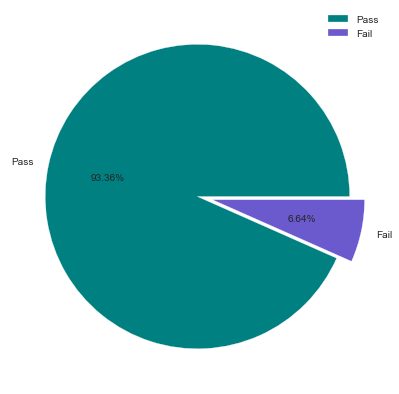

-1    1463
 1     104
Name: status, dtype: int64

In [126]:
#pie chart for 'status(fail-pass)
plt.rcParams['figure.figsize'] = (7,7)
labels = ['Pass', 'Fail']
size = df['status'].value_counts()
colors = ['teal', 'slateblue']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%")
plt.axis('off')
plt.legend()
plt.show()
df['status'].value_counts()

In [127]:
#descriptive analysis
def eda(df,output):
    #output={}
    for col in df.columns:
        mean=df[col].mean()
        std= df[col].std()
        percent_null= pd.isnull(df[col]).sum()/len(df[col])*100
        unique=len(pd.unique(df[col]))
        outlier_df3= df[(np.abs(stats.zscore(df[col])) > 3)]
        outlier_df2= df[(np.abs(stats.zscore(df[col])) > 2)]
        count_3s_perc=len(outlier_df3)*100/len(df)
        count_2s_perc=(len(outlier_df2)-len(outlier_df3))*100/len(df)
        min= df[col].min()
        q25=df[col].quantile(0.25)
        q50=df[col].quantile(0.5)
        q75=df[col].quantile(0.75)
        max= df[col].max()
        skewness=df[col].skew()
        kurtosis=df[col].kurtosis()
        list = []
        list.append(mean)
        list.append(std)
        list.append(percent_null)
        list.append(unique)
        list.append(count_3s_perc)
        list.append(count_2s_perc)
        list.append(min)
        list.append(q25)
        list.append(q50)
        list.append(q75)
        list.append(max)
        list.append(skewness)
        list.append(kurtosis)
        output[col] = list
    return output;

In [128]:
#dictionary for EDA
result={}
result=eda(df_features,result)
result1=pd.DataFrame.from_dict(result,orient='index')
result1.columns=['mean','std', 'percent_null', 'unique', 'count_3s_perc', 'count_2s_perc', 'min', 'q25', 'q50', 'q75', 'max','skewness','kurtosis']
result1

,mean,std,percent_null,unique,count_3s_perc,count_2s_perc,min,q25,q50,q75,max,skewness,kurtosis
feature1,3014.452896,73.621787,0.382897,1521,0.0,0.0,2743.2400,2966.260000,3011.49000,3056.650000,3356.3500,0.513657,1.470652
feature2,2495.850231,80.407705,0.446713,1505,0.0,0.0,2158.7500,2452.247500,2499.40500,2538.822500,2846.4400,-0.043066,2.241442
feature3,2200.547318,29.513152,0.893427,508,0.0,0.0,2060.6600,2181.044400,2201.06670,2218.055500,2315.2667,-0.305764,2.304955
feature4,1396.376627,441.691640,0.893427,519,0.0,0.0,0.0000,1081.875800,1285.21440,1591.223500,3715.0417,1.711627,4.594917
feature5,4.197013,56.355540,0.893427,504,0.0,0.0,0.6815,1.017700,1.31680,1.525700,1114.5366,19.645262,384.452750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature586,3.067826,3.578033,0.063816,1503,0.0,0.0,1.1975,2.306500,2.75765,3.295175,99.3032,24.697136,659.562151
feature587,0.021458,0.012358,0.063816,323,0.0,0.0,-0.0169,0.013425,0.02050,0.027600,0.1028,1.438025,6.975957
feature588,0.016475,0.008808,0.063816,261,0.0,0.0,0.0032,0.010600,0.01480,0.020300,0.0799,1.947408,7.092926
feature589,0.005283,0.002867,0.063816,121,0.0,0.0,0.0010,0.003300,0.00460,0.006400,0.0286,2.029372,8.238837


# Missing Values

In [129]:
#Checking if there is any missing value in the data 
df.isna().any().any()

True

In [130]:
#percentage of null values for each column
df_nulls = df.isna().sum()/(len(df))*100

In [131]:
df_nulls

feature1      0.382897
feature2      0.446713
feature3      0.893427
feature4      0.893427
feature5      0.893427
                ...   
feature588    0.063816
feature589    0.063816
feature590    0.063816
status        0.000000
timestamp     0.000000
Length: 592, dtype: float64

In [132]:
df.loc[:, df.isnull().any()].columns

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
       'feature7', 'feature8', 'feature9', 'feature10',
       ...
       'feature581', 'feature582', 'feature583', 'feature584', 'feature585',
       'feature586', 'feature587', 'feature588', 'feature589', 'feature590'],
      dtype='object', length=538)

In [133]:
merge_data= pd.concat([df_features,df_target],axis=1)

In [134]:
df_nulls=pd.DataFrame(df_nulls)
df_nulls

,0
feature1,0.382897
feature2,0.446713
feature3,0.893427
feature4,0.893427
feature5,0.893427
...,...
feature588,0.063816
feature589,0.063816
feature590,0.063816
status,0.000000


In [135]:
print("Column with lowest amount of missings contains {} % missings.".format(df_nulls.min()))
print("Column with highest amount of missings contains {} % missings.".format(df_nulls.max()))

Column with lowest amount of missings contains 0    0.0
dtype: float64 % missings.
Column with highest amount of missings contains 0    91.193363
dtype: float64 % missings.


In [136]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [137]:
df_na = null_values(df_features)
df_na

,Missing_Records,Percentage (%)
feature293,1429,91.193363
feature294,1429,91.193363
feature158,1429,91.193363
feature159,1429,91.193363
feature359,1341,85.577537
...,...,...
feature457,1,0.063816
feature219,1,0.063816
feature357,1,0.063816
feature458,1,0.063816


In [138]:
#general arrangement for visualization 
large = 16; med = 12; small = 8
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

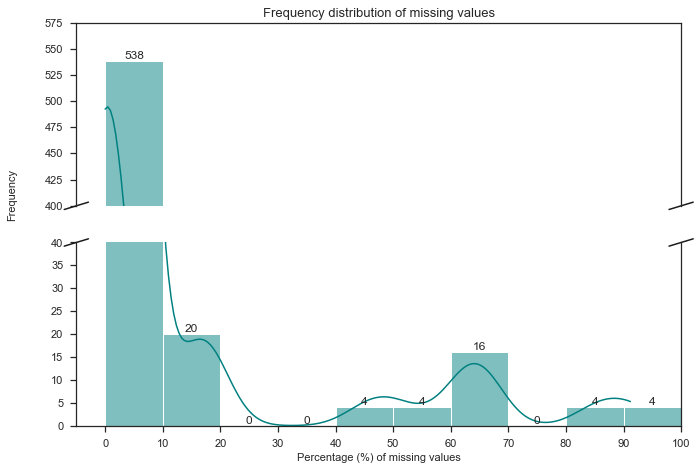

In [139]:
#broken axis bar chart for percentage of missing values before splitting data 
sns.set(style="whitegrid", font="CMU Sans Serif" )
sns.set_style("ticks")

pal = sns.color_palette(n_colors=3)

f, (ax1,ax2)= plt.subplots(2,1,sharex = True,sharey=False,figsize=(12, 8))
ax1 = sns.histplot(x="percent_null",
                   data=result1, palette=pal, ax=ax1,kde= True, bins=(0,10,20,30,40,50,60,70,80,90,100),color="teal")
sns.set(style="whitegrid", font="CMU Sans Serif" )
sns.set_style("ticks")

ax2 = sns.histplot(x="percent_null",
                   data=result1, palette=pal, ax=ax2,kde= True,bins=(0,10,20,30,40,50,60,70,80,90,100), color="teal")

ax1.set_title('Frequency distribution of missing values', fontsize=13)

ax2.bar_label(ax2.containers[0])
ax1.bar_label(ax1.containers[0])

plt.xticks(rotation=0,fontsize=11)

ax1.set_ylim(400, 575)
ax2.set_ylim(0, 40)
plt.xlim(-5, 100)
plt.xticks([0, 10,20, 30, 40, 50, 60, 70, 80,90, 100, ])

ax1.get_xaxis().set_visible(False)

ax1.set_ylabel("")
ax2.set_ylabel("")
ax2.set_xlabel("Percentage (%) of missing values",size=11)
# then, set a new label on the plot (basically just a piece of text) and move it to where it makes sense (requires trial and error)
f.text(0.07, 0.55,"Frequency", va="center", rotation="vertical",size=11)

ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
plt.show()

In [140]:
#features that have missing values bigger than 5%
df_na_1 = df_na[df_na["Percentage (%)"] > 15]
df_na_1

,Missing_Records,Percentage (%)
feature293,1429,91.193363
feature294,1429,91.193363
feature158,1429,91.193363
feature159,1429,91.193363
feature359,1341,85.577537
feature86,1341,85.577537
feature493,1341,85.577537
feature221,1341,85.577537
feature519,1018,64.964901
feature247,1018,64.964901


Text(0.5, 1.0, 'Percentage of Missing Values > 15% per feature ')

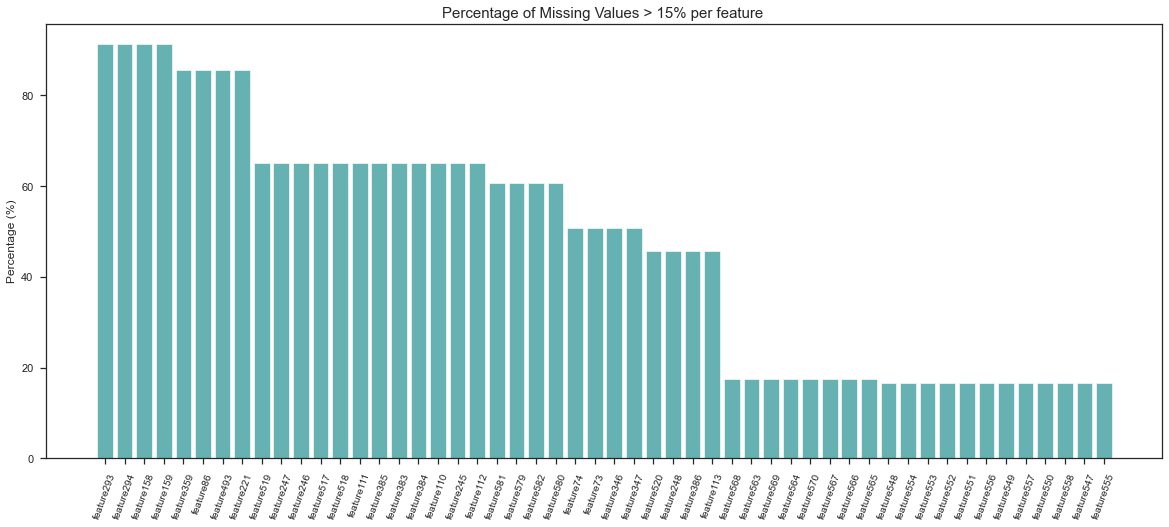

In [141]:
# percantage of missing values for each feature > 5%
plt.rcParams['figure.figsize'] = (20, 8)
df_nulls_3 = plt.bar(x=df_na_1.index, height= df_na_1['Percentage (%)'], facecolor='teal', alpha=0.6)
plt.xticks(rotation=70,fontsize=10)
plt.ylabel("Percentage (%)",size=12)
plt.title("Percentage of Missing Values > 15% per feature ",size=15)
 

In [142]:
df_na_sort= pd.DataFrame(df_na['Percentage (%)'].sort_values(ascending=False))
df_na_sort

,Percentage (%)
feature293,91.193363
feature159,91.193363
feature294,91.193363
feature158,91.193363
feature86,85.577537
...,...
feature584,0.063816
feature585,0.063816
feature586,0.063816
feature588,0.063816


In [143]:
df_descriptive=df.describe().transpose()

In [144]:
df_std=df_features.std()
df.std()

feature1                       73.621787
feature2                       80.407705
feature3                       29.513152
feature4                       441.69164
feature5                        56.35554
                         ...            
feature588                      0.008808
feature589                      0.002867
feature590                     93.891919
status                           0.49801
timestamp     22 days 15:52:35.606333074
Length: 592, dtype: object

In [145]:
#Observation is that most of the variables distribution are right skewed with long tails and outliers 
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20,10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout() 
    plt.show()

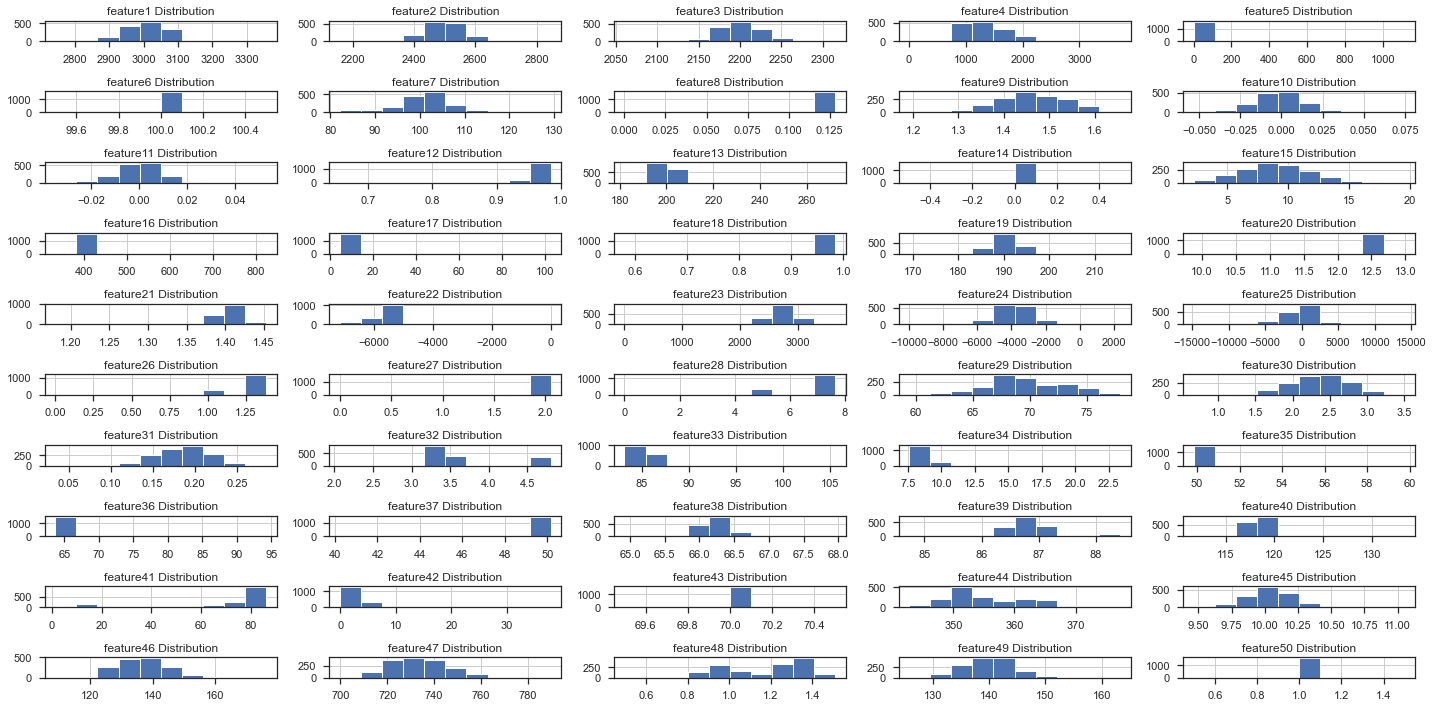

In [146]:
# general idea how skewed data
draw_histograms(df, df.iloc[:,0:50], 10, 5)

In [147]:
df.iloc[:, 0:590]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.0047,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,NaN,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.0025,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941


In [148]:
df_eda=df.describe().T

In [149]:
#number of features with zero std 
df_eda[df_eda['std']==0]

,count,mean,std,min,25%,50%,75%,max
feature6,1553.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
feature14,1564.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,1566.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
feature50,1566.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature53,1566.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
feature535,1558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,1558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,1558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,1558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Volatility 

In [150]:
#scaling data for volatility check 
scaler = MinMaxScaler()
df_features= read_secom()
df_target = read_labels()
#It seems like the Scaler works only with series. When we scale the whole dataframe, the datafram will be broken down.
#Then we need to form the dataframe again.
df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
df_features_scaled

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.469231,0.589292,0.499096,0.379841,0.000609,0.0,0.328562,0.965785,0.665019,0.542479,...,NaN,NaN,0.709375,0.012325,0.017510,0.011880,NaN,NaN,NaN,NaN
1,0.575003,0.445535,0.666763,0.393982,0.000133,0.0,0.428942,0.969673,0.656639,0.412315,...,0.181159,0.282386,0.753125,0.034637,0.036965,0.033099,0.221387,0.220339,0.181159,0.282386
2,0.308868,0.583388,0.493903,0.457065,0.000744,0.0,0.283455,0.965008,0.542759,0.448168,...,0.500000,0.112383,0.562500,0.020612,0.021401,0.020152,0.629073,0.589309,0.500000,0.112383
3,0.400385,0.466998,0.543479,0.244894,0.000574,0.0,0.469123,0.946345,0.638590,0.319564,...,0.123188,0.100153,0.662500,0.009137,0.007782,0.008734,0.309942,0.152542,0.123188,0.100153
4,0.471367,0.500400,0.678327,0.357067,0.000765,0.0,0.387631,0.960342,0.670606,0.392050,...,NaN,NaN,0.068750,1.000000,1.000000,1.000000,0.309942,0.152542,0.123188,0.100153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.254718,0.444401,0.467675,0.830510,0.000721,0.0,0.002453,0.970451,0.325312,0.381138,...,0.134058,0.275560,0.656250,0.017637,0.021401,0.017016,0.197995,0.138201,0.134058,0.275560
1563,0.504102,0.529017,0.541646,0.302731,0.000175,0.0,0.346719,0.937014,0.520627,0.368667,...,NaN,NaN,0.615625,0.015087,0.018482,0.014538,0.197995,0.138201,0.134058,0.275560
1564,0.384221,0.321409,0.572020,0.298919,0.000128,0.0,0.366738,0.939347,NaN,NaN,...,0.054348,0.059030,0.653125,0.019762,0.023346,0.018974,0.305764,0.070404,0.054348,0.059030
1565,0.247394,0.542774,0.457071,0.318631,0.000800,0.0,0.353699,0.943235,0.582725,0.360094,...,0.235507,0.126805,0.706250,0.025074,0.020428,0.024144,0.360067,0.277705,0.235507,0.126805


In [151]:
df_eda = df_features_scaled.describe().T
df_eda

,count,mean,std,min,25%,50%,75%,max
feature1,1561.0,0.442356,0.120079,0.0,0.363752,0.437523,0.511181,1.0
feature2,1560.0,0.490192,0.116924,0.0,0.426788,0.495361,0.552680,1.0
feature3,1553.0,0.549425,0.115917,0.0,0.472825,0.551465,0.618191,1.0
feature4,1553.0,0.375871,0.118893,0.0,0.291215,0.345949,0.428319,1.0
feature5,1553.0,0.003156,0.050595,0.0,0.000302,0.000570,0.000758,1.0
...,...,...,...,...,...,...,...,...
feature586,1566.0,0.019064,0.036471,0.0,0.011304,0.015903,0.021382,1.0
feature587,1566.0,0.320455,0.103243,0.0,0.253342,0.312448,0.371763,1.0
feature588,1566.0,0.173076,0.114831,0.0,0.096480,0.151239,0.222947,1.0
feature589,1566.0,0.155193,0.103879,0.0,0.083333,0.130435,0.195652,1.0


In [152]:
#changing background of the graphs
plt.rcParams['axes.facecolor'] = 'whitesmoke'

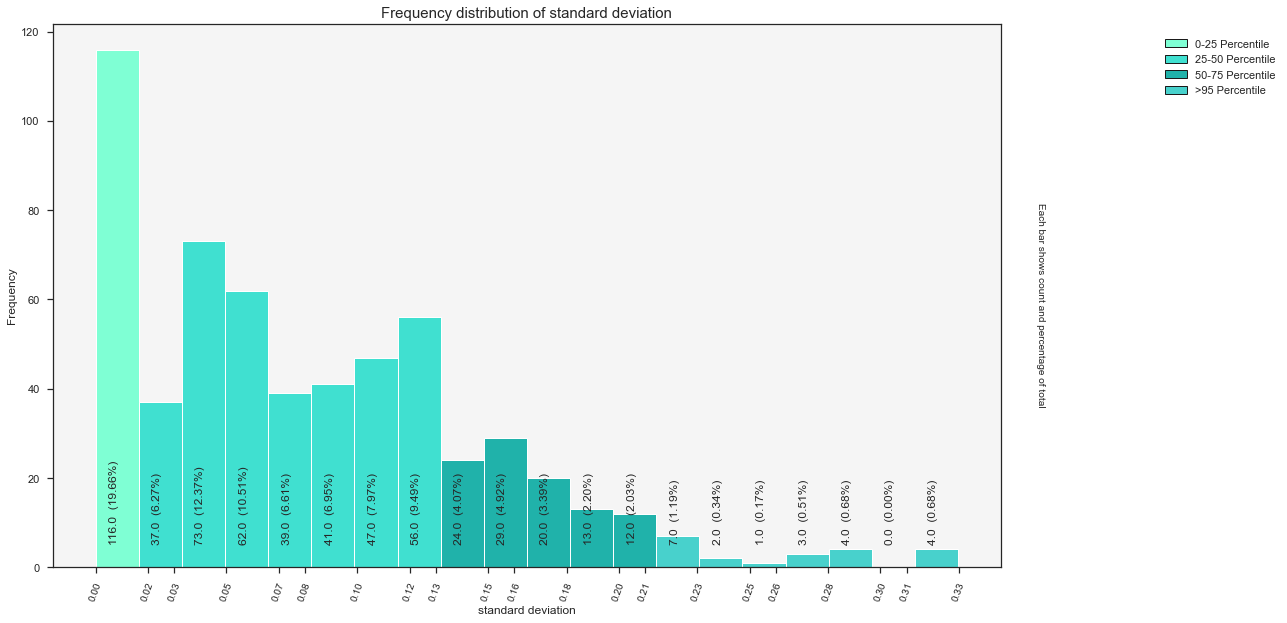

In [153]:
# volatility histogram without line
# Colours for different percentiles
perc_25_colour = 'aquamarine'
perc_50_colour = 'turquoise'
perc_75_colour = 'lightseagreen'
perc_95_colour = 'mediumturquoise'

fig, ax = plt.subplots(figsize=(17,10))

counts, bins, patches = ax.hist(df_eda['std'], facecolor=perc_50_colour, bins=20, edgecolor='white')

ax.set_xticks(bins.round(2))
plt.xticks(rotation=70,fontsize=10)

ax.set_title('Frequency distribution of standard deviation', fontsize=15)
ax.set_xlabel('standard deviation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

twentyfifth, seventyfifth, ninetyfifth = np.percentile(df_eda['std'], [25, 75, 95])
for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
    if rightside < twentyfifth:
        patch.set_facecolor(perc_25_colour)
    elif leftside > ninetyfifth:
        patch.set_facecolor(perc_95_colour)
    elif leftside > seventyfifth:
        patch.set_facecolor(perc_75_colour)
        
bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

for i in range(len(bins)-1):
    bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

ax.annotate('Each bar shows count and percentage of total',
            xy=(.85,.30), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='bottom',
            fontsize=10, bbox=dict(boxstyle="round", fc="white"),
            rotation=-90)

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))

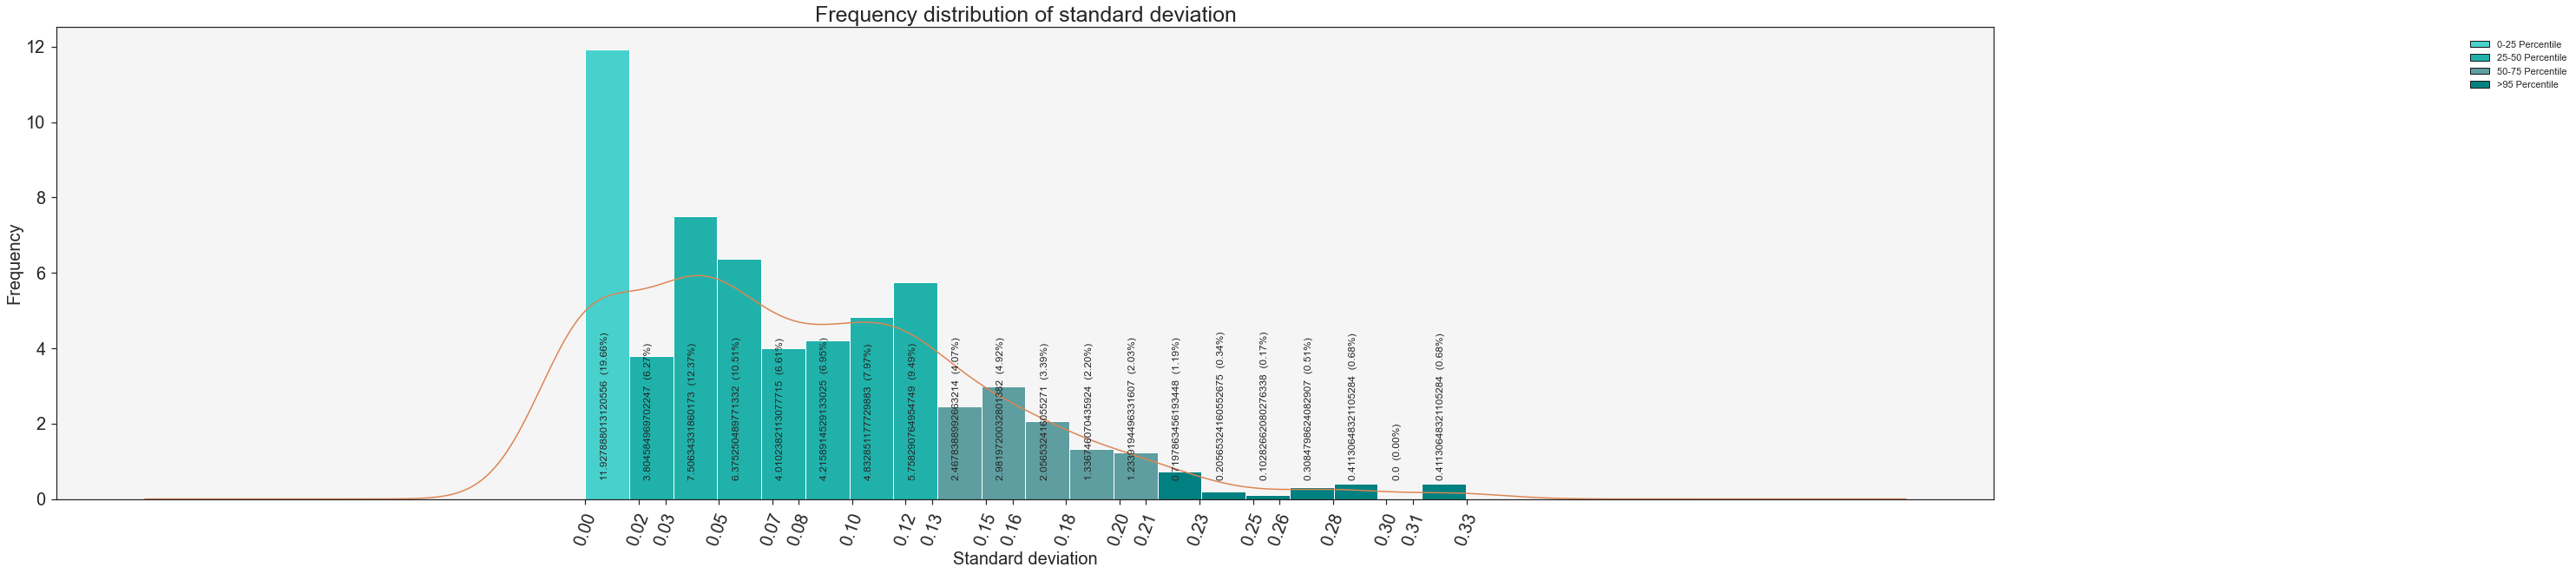

In [154]:
# volatility histogram with line
# Colours for different percentiles
perc_25_colour = 'mediumturquoise'
perc_50_colour = 'lightseagreen'
perc_75_colour = 'cadetblue'
perc_95_colour = 'teal'

# Plot the Histogram 
fig, ax = plt.subplots(figsize=(40,10))

counts, bins, patches = ax.hist(df_eda['std'], facecolor=perc_50_colour, bins=20, edgecolor='white',density=True)

df_eda['std'].plot(kind = "kde")

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins.round(2))
plt.xticks(rotation=70,fontsize=20)
plt.yticks(fontsize=20)

# Set the graph title and axes titles
ax.set_title('Frequency distribution of standard deviation', fontsize=25)
ax.set_xlabel('Standard deviation', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)


# Change the colors of bars at the edges
twentyfifth, seventyfifth, ninetyfifth = np.percentile(df_eda['std'], [25, 75, 95])
for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
    if rightside < twentyfifth:
        patch.set_facecolor(perc_25_colour)
    elif leftside > ninetyfifth:
        patch.set_facecolor(perc_95_colour)
    elif leftside > seventyfifth:
        patch.set_facecolor(perc_75_colour)
        

bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

for i in range(len(bins)-1):
    bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')


#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))

In [155]:
df_eda_sort = df_eda['std'].sort_values(ascending=False)

In [156]:
result1['percent_null'].value_counts().sort_index()

0.000000      52
0.063816      92
0.127632      84
0.191449      24
0.255265      24
0.319081       3
0.382897     100
0.446713      20
0.510530      12
0.574346      48
0.638162       4
0.765795       4
0.893427      20
1.531589      43
3.254627       8
16.592214     12
17.421825      8
45.628590      4
50.670070      4
60.561583      4
64.964901     12
85.577537      4
91.193363      4
Name: percent_null, dtype: int64

# Splitting data and New Charts

In [157]:
#data set accoring to pass or fail 
#unique_vals = merge_data['status'].unique()  # [0, 1, 2]
#targets = [merge_data.loc[merge_data['status'] == val] for val in unique_vals]
merge_data
#separate target variable and remaining data
x = merge_data.iloc[:,:590]
y = merge_data.iloc[:,590]
y

0      -1
1      -1
2       1
3      -1
4      -1
       ..
1562   -1
1563   -1
1564   -1
1565   -1
1566   -1
Name: status, Length: 1567, dtype: int64


# splitting merge_data into train test and split

<AxesSubplot:>

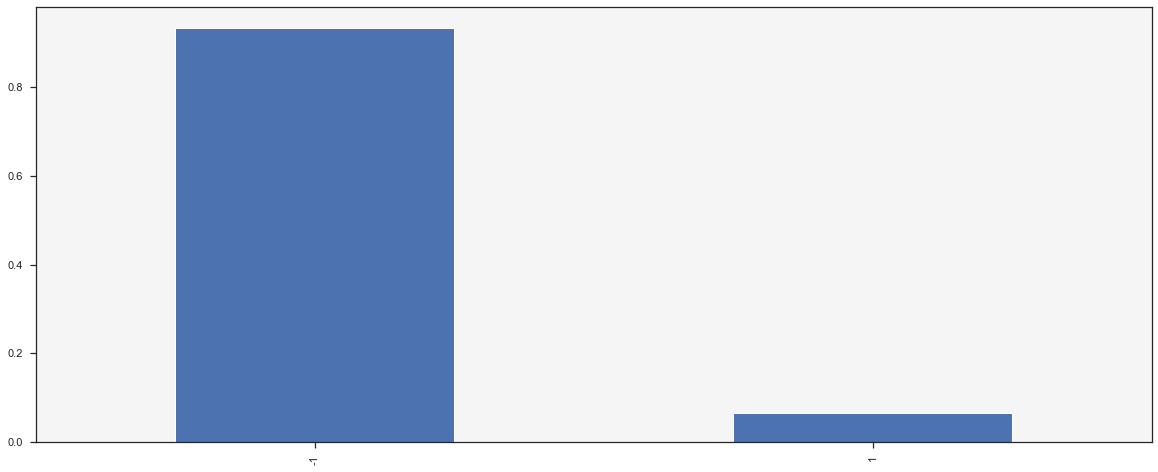

In [158]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1,stratify=y)# random state = fix the random generator (same data all time)
#startify preserves the same proportions of examples in each class as observed in the original dataset- imbalance data .
#frequency count of target varaible in training and test data separately (after splitting)
#x_train - 1253.590
#x_test - 314.590
#y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)
y_train.value_counts(normalize=True).plot(kind='bar')

In [159]:
x_train
##proceeding with only training data 
#analysis of volatility and null values of training data 
#xtrain_desc = x_train.describe()
xtrain_eda={}
xtrain_eda=eda(x_train,xtrain_eda)
xtrain_eda1=pd.DataFrame.from_dict(xtrain_eda,orient='index')
xtrain_eda1.columns=['mean','std', 'percent_null', 'unique', 'count_3s', 'count_2s', 'min', 'q25', 'q50', 'q75', 'max','skewness','kurtosis']
#Percent_null of features before split 
#sns.histplot(data=result1, x='percent_null',bins=20, kde=True)
xtrain_eda1

,mean,std,percent_null,unique,count_3s,count_2s,min,q25,q50,q75,max,skewness,kurtosis
feature1,3014.113686,73.877303,0.399042,1227,0.0,0.0,2743.2400,2966.2300,3011.40500,3056.310000,3356.3500,0.543580,1.589958
feature2,2496.400585,79.188651,0.478851,1213,0.0,0.0,2162.8700,2452.3350,2500.38000,2539.600000,2846.4400,-0.050951,2.281719
feature3,2200.216525,29.939025,0.798085,479,0.0,0.0,2060.6600,2180.8611,2200.98890,2218.055500,2315.2667,-0.393137,2.541922
feature4,1394.907987,436.632421,0.798085,490,0.0,0.0,0.0000,1083.8858,1283.43680,1593.122000,3715.0417,1.609379,4.102406
feature5,4.018582,54.572445,0.798085,478,0.0,0.0,0.6815,1.0160,1.31710,1.525700,1114.5366,20.304107,410.943471
...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature586,3.084501,3.968128,0.079808,1208,0.0,0.0,1.1975,2.3058,2.74655,3.258475,99.3032,22.636508,545.053032
feature587,0.021521,0.012421,0.079808,306,0.0,0.0,-0.0060,0.0134,0.02070,0.027600,0.1028,1.571819,7.780914
feature588,0.016344,0.008698,0.079808,249,0.0,0.0,0.0042,0.0106,0.01480,0.019800,0.0799,2.082862,8.230885
feature589,0.005248,0.002850,0.079808,117,0.0,0.0,0.0012,0.0033,0.00460,0.006300,0.0286,2.137793,9.345498


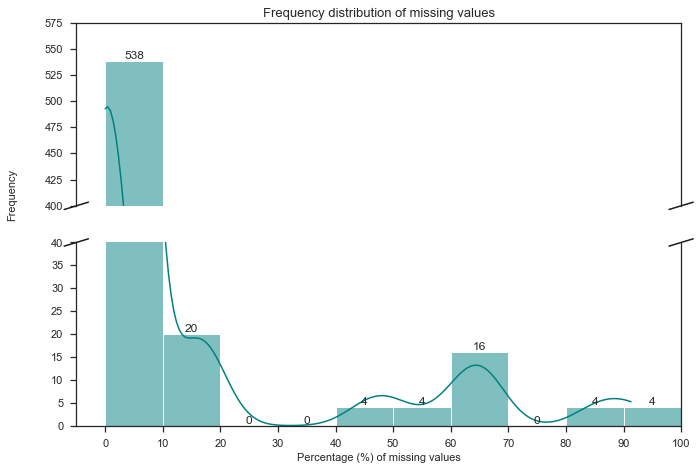

In [160]:
#Missing values after splitting data 
#broken axis bar chart for percentage of missing_values
sns.set(style="whitegrid", font="CMU Sans Serif" )
sns.set_style("ticks")

pal = sns.color_palette(n_colors=3)

f, (ax1,ax2)= plt.subplots(2,1,sharex = True,sharey=False,figsize=(12, 8))
ax1 = sns.histplot(x="percent_null",
                   data=xtrain_eda1, palette=pal, ax=ax1,kde= True, bins=(0,10,20,30,40,50,60,70,80,90,100),color="teal")
sns.set(style="whitegrid", font="CMU Sans Serif" )
sns.set_style("ticks")

ax2 = sns.histplot(x="percent_null",
                   data=xtrain_eda1, palette=pal, ax=ax2,kde= True,bins=(0,10,20,30,40,50,60,70,80,90,100), color="teal")

ax1.set_title('Frequency distribution of missing values', fontsize=13)

ax2.bar_label(ax2.containers[0])
ax1.bar_label(ax1.containers[0])

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins.round(2))
plt.xticks(rotation=0,fontsize=11)

ax1.set_ylim(400, 575)
ax2.set_ylim(0, 40)
plt.xlim(-5, 100)
plt.xticks([0, 10,20, 30, 40, 50, 60, 70, 80,90, 100, ])

ax1.get_xaxis().set_visible(False)

ax1.set_ylabel("")
ax2.set_ylabel("")
ax2.set_xlabel("Percentage (%) of missing values",size=11)

f.text(0.07, 0.55,"Frequency", va="center", rotation="vertical",size=11)

# Ticks on the top of the upper part and bottom of the lower part for style
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
d = .02  

kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs) 

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
plt.show()

In [161]:
#checking features with zero standard deviation
xtrain_eda1[xtrain_eda1['std']== 0]

,mean,std,percent_null,unique,count_3s,count_2s,min,q25,q50,q75,max,skewness,kurtosis
feature6,100.0,0.0,0.798085,2,0.0,0.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0
feature14,0.0,0.0,0.159617,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,70.0,0.0,0.000000,1,0.0,0.0,70.0,70.0,70.0,70.0,70.0,0.0,0.0
feature50,1.0,0.0,0.000000,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
feature53,0.0,0.0,0.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature535,0.0,0.0,0.478851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,0.0,0.0,0.478851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,0.0,0.0,0.478851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,0.0,0.0,0.478851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
#scaling after splitting data 
scaler = MinMaxScaler()
df_features_scaled_2 = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
df_features_scaled_2

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.548890,0.280352,0.574943,0.341748,0.000966,0.0,0.315948,0.949456,0.579502,0.537023,...,0.171533,0.093237,0.696875,0.010625,0.015579,0.010116,0.314338,0.200793,0.171533,0.093237
1,0.421001,0.480360,0.371754,0.247162,0.000533,0.0,0.486336,0.954121,0.493339,0.375682,...,NaN,NaN,0.515625,0.029537,0.023369,0.028890,0.210478,0.309115,0.251825,0.222431
2,0.488558,0.314554,0.443019,0.385910,0.000313,0.0,0.602938,0.968118,0.656210,0.575214,...,NaN,NaN,0.575000,0.011475,0.015579,0.011113,0.246324,0.323646,0.288321,0.187556
3,0.449185,0.349533,0.641538,0.406477,0.000790,0.0,0.375605,0.932348,0.541040,0.330475,...,0.094891,0.067474,0.840625,0.008712,0.012658,0.008106,0.316176,0.130779,0.094891,0.067474
4,0.451876,0.396624,0.617231,0.469652,0.000252,0.0,0.383009,0.947123,0.653202,0.340608,...,NaN,NaN,0.725000,0.018487,0.017527,0.017698,0.206801,0.095112,0.113139,0.093567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.512257,0.466170,0.605928,0.447829,0.000304,0.0,0.388669,0.969673,0.627417,0.160561,...,NaN,NaN,0.809375,0.024437,0.020448,0.023200,0.296875,0.099075,0.076642,0.060177
1249,0.434620,0.589055,0.644201,0.352257,0.000637,0.0,0.403263,0.939347,0.543618,0.354638,...,NaN,NaN,0.628125,0.003825,0.005842,0.003821,0.307904,0.228534,0.233577,0.105953
1250,0.474792,0.685519,0.464970,0.545948,0.000784,0.0,0.282135,0.959565,0.509454,0.454404,...,NaN,NaN,0.593750,0.014450,0.016553,0.014122,0.329044,0.097754,0.098540,0.052866
1251,0.459901,0.498018,0.467675,0.830510,0.000721,0.0,0.002453,0.970451,0.381822,0.361652,...,0.014599,0.062535,0.753125,0.020824,0.024343,0.019829,0.165441,0.017173,0.014599,0.062535


In [163]:
df_eda_2 = df_features_scaled_2.describe().T
df_eda_2

,count,mean,std,min,25%,50%,75%,max
feature1,1248.0,0.441803,0.120496,0.0,0.363703,0.437385,0.510626,1.0
feature2,1247.0,0.487925,0.115846,0.0,0.423461,0.493746,0.551121,1.0
feature3,1243.0,0.548126,0.117589,0.0,0.472105,0.551159,0.618191,1.0
feature4,1243.0,0.375476,0.117531,0.0,0.291756,0.345470,0.428830,1.0
feature5,1243.0,0.002996,0.048994,0.0,0.000300,0.000571,0.000758,1.0
...,...,...,...,...,...,...,...,...
feature586,1252.0,0.019234,0.040447,0.0,0.011297,0.015790,0.021008,1.0
feature587,1252.0,0.252953,0.114163,0.0,0.178309,0.245404,0.308824,1.0
feature588,1252.0,0.160424,0.114907,0.0,0.084544,0.140026,0.206077,1.0
feature589,1252.0,0.147734,0.104011,0.0,0.076642,0.124088,0.186131,1.0


Text(0.85, 0.3, 'Each bar shows count and percentage of total')

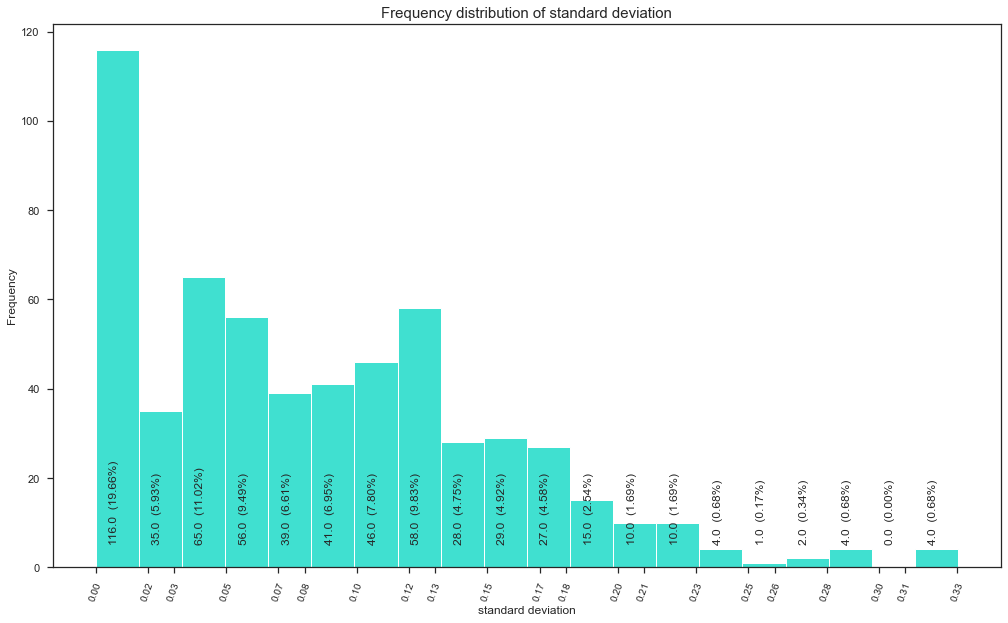

In [164]:
# Volatility graph after splitting data without line
# Colours for different percentiles
perc_25_colour = 'aquamarine'
perc_50_colour = 'turquoise'
perc_75_colour = 'lightseagreen'
perc_95_colour = 'mediumturquoise'

# Plot the Histogram from the random data
fig, ax = plt.subplots(figsize=(17,10))

counts, bins, patches = ax.hist(df_eda_2['std'], facecolor=perc_50_colour, bins=20, edgecolor='white')

ax.set_xticks(bins.round(2))
plt.xticks(rotation=70,fontsize=10)

# Set the graph title and axes titles
ax.set_title('Frequency distribution of standard deviation', fontsize=15)
ax.set_xlabel('standard deviation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
        
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

# Annotation for bar values
ax.annotate('Each bar shows count and percentage of total',
            xy=(.85,.30), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='bottom',
            fontsize=10, bbox=dict(boxstyle="round", fc="white"),
            rotation=-90)


Text(0.85, 0.3, 'Each bar shows count and percentage of total')

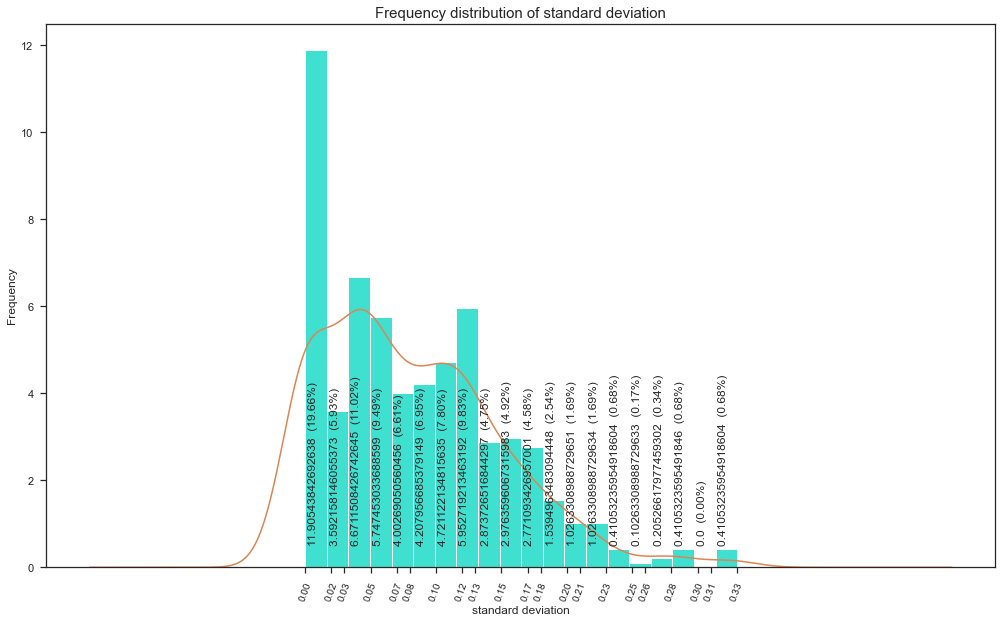

In [165]:
# Volatility after splitting data 
# Colours for different percentiles
perc_25_colour = 'aquamarine'
perc_50_colour = 'turquoise'
perc_75_colour = 'lightseagreen'
perc_95_colour = 'mediumturquoise'

# Plot the Histogram from the random data
fig, ax = plt.subplots(figsize=(17,10))

counts, bins, patches = ax.hist(df_eda_2['std'], facecolor=perc_50_colour, bins=20, edgecolor='white',density=True)

df_eda['std'].plot(kind = "kde")


# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins.round(2))
plt.xticks(rotation=70,fontsize=10)

# Set the graph title and axes titles
ax.set_title('Frequency distribution of standard deviation', fontsize=15)
ax.set_xlabel('standard deviation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

        
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

# Annotation for bar values
ax.annotate('Each bar shows count and percentage of total',
            xy=(.85,.30), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='bottom',
            fontsize=10, bbox=dict(boxstyle="round", fc="white"),
            rotation=-90)


removing missing values 

In [166]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [167]:
x_train_na = null_values(x_train)
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
...,...,...
feature500,1,0.079808
feature367,1,0.079808
feature377,1,0.079808
feature378,1,0.079808


In [168]:
x_train_na= x_train_na[x_train_na["Percentage (%)"] > 80]
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
feature86,1072,85.554669
feature359,1072,85.554669
feature493,1072,85.554669


In [169]:
x_train_new = x_train.drop(axis=1, columns=x_train_na.index)
x_train_new.shape

(1253, 582)

removing std=0 features

In [170]:
x_train_new
##proceeding with only training data 
#analysis of volatility and null values of training data 
#xtrain_desc = x_train.describe()
x_train_new_eda={}
x_train_new_eda=eda(x_train_new,x_train_new_eda)
x_train_new_eda1=pd.DataFrame.from_dict(x_train_new_eda,orient='index')
x_train_new_eda1.columns=['mean','std', 'percent_null', 'unique', 'count_3s', 'count_2s', 'min', 'q25', 'q50', 'q75', 'max','skewness','kurtosis']
#Percent_null of features before split 
#sns.histplot(data=result1, x='percent_null',bins=20, kde=True)
x_train_new_eda1

,mean,std,percent_null,unique,count_3s,count_2s,min,q25,q50,q75,max,skewness,kurtosis
feature1,3014.113686,73.877303,0.399042,1227,0.0,0.0,2743.2400,2966.2300,3011.40500,3056.310000,3356.3500,0.543580,1.589958
feature2,2496.400585,79.188651,0.478851,1213,0.0,0.0,2162.8700,2452.3350,2500.38000,2539.600000,2846.4400,-0.050951,2.281719
feature3,2200.216525,29.939025,0.798085,479,0.0,0.0,2060.6600,2180.8611,2200.98890,2218.055500,2315.2667,-0.393137,2.541922
feature4,1394.907987,436.632421,0.798085,490,0.0,0.0,0.0000,1083.8858,1283.43680,1593.122000,3715.0417,1.609379,4.102406
feature5,4.018582,54.572445,0.798085,478,0.0,0.0,0.6815,1.0160,1.31710,1.525700,1114.5366,20.304107,410.943471
...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature586,3.084501,3.968128,0.079808,1208,0.0,0.0,1.1975,2.3058,2.74655,3.258475,99.3032,22.636508,545.053032
feature587,0.021521,0.012421,0.079808,306,0.0,0.0,-0.0060,0.0134,0.02070,0.027600,0.1028,1.571819,7.780914
feature588,0.016344,0.008698,0.079808,249,0.0,0.0,0.0042,0.0106,0.01480,0.019800,0.0799,2.082862,8.230885
feature589,0.005248,0.002850,0.079808,117,0.0,0.0,0.0012,0.0033,0.00460,0.006300,0.0286,2.137793,9.345498


In [171]:
x_train_new_eda1[x_train_new_eda1['std']==0]
x_train_new_std= x_train_new_eda1[x_train_new_eda1["std"] == 0]
x_train_new_std

,mean,std,percent_null,unique,count_3s,count_2s,min,q25,q50,q75,max,skewness,kurtosis
feature6,100.0,0.0,0.798085,2,0.0,0.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0
feature14,0.0,0.0,0.159617,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,70.0,0.0,0.000000,1,0.0,0.0,70.0,70.0,70.0,70.0,70.0,0.0,0.0
feature50,1.0,0.0,0.000000,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
feature53,0.0,0.0,0.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature535,0.0,0.0,0.478851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,0.0,0.0,0.478851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,0.0,0.0,0.478851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,0.0,0.0,0.478851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
x_train_new_2 = x_train_new.drop(axis=1, columns=x_train_new_std.index)
x_train_new_2.shape

(1253, 466)

In [173]:
x_train_new_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253 entries, 443 to 181
Columns: 466 entries, feature1 to feature590
dtypes: float64(466)
memory usage: 4.5 MB


In [174]:
print(x_train_new_2.isnull().sum())

feature1       5
feature2       6
feature3      10
feature4      10
feature5      10
              ..
feature586     1
feature587     1
feature588     1
feature589     1
feature590     1
Length: 466, dtype: int64


outlier treatment


In [178]:
x_train_3s=x_train_new_2.copy()

In [179]:
def zscore(df,cols,thr):
    for col in cols:
        mean=df[col].mean()
        std=df[col].std()
        upper_bound=mean+ thr*std
        lower_bound=mean- thr*std
        df[col]=np.where(df[col]>upper_bound,upper_bound,np.where(df[col]<lower_bound,lower_bound,df[col]))

In [180]:
zscore(x_train_3s,x_train_3s.columns,3)


In [181]:
x_train_3s

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
443,3079.77,2354.51,2207.0444,1269.607800,1.7571,97.018900,0.1221,1.4607,0.0155,0.0093,...,0.0059,68.7444,0.5001,0.0110,0.0034,2.1899,0.0282,0.0194,0.0059,68.7444
760,3001.36,2491.23,2155.3111,918.216100,1.2753,105.047800,0.1227,1.4206,-0.0052,0.0010,...,NaN,NaN,0.4943,0.0199,0.0042,4.0318,0.0169,0.0276,0.0081,163.9998
479,3042.78,2377.89,2173.4556,1433.673200,1.0304,110.542200,0.1245,1.4964,0.0204,0.0133,...,NaN,NaN,0.4962,0.0114,0.0034,2.2877,0.0208,0.0287,0.0091,138.2861
362,3018.64,2401.80,2224.0000,1510.079700,1.5611,99.830000,0.1199,1.4428,-0.0110,0.0101,...,0.0038,49.7490,0.5047,0.0101,0.0031,1.9927,0.0284,0.0141,0.0038,49.7490
662,3020.29,2433.99,2217.8111,1744.777100,0.9618,100.178900,0.1218,1.4950,-0.0097,-0.0054,...,NaN,NaN,0.5010,0.0147,0.0036,2.9338,0.0165,0.0114,0.0043,68.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,3057.31,2481.53,2214.9333,1663.702400,1.0203,100.445600,0.1247,1.4830,-0.0328,0.0048,...,NaN,NaN,0.5037,0.0175,0.0039,3.4736,0.0263,0.0117,0.0033,44.3686
821,3009.71,2565.53,2224.6778,1308.647900,1.3907,101.133300,0.1208,1.4440,-0.0079,-0.0076,...,NaN,NaN,0.4979,0.0078,0.0024,1.5724,0.0275,0.0215,0.0076,78.1199
213,3034.34,2631.47,2179.0445,2028.220800,1.5552,95.425600,0.1234,1.4281,0.0049,0.0092,...,NaN,NaN,0.4968,0.0128,0.0035,2.5829,0.0298,0.0116,0.0039,38.9781
1556,3025.21,2503.30,2179.7333,2704.805249,1.4843,82.357569,0.1248,1.3687,-0.0070,-0.0033,...,0.0016,46.1076,0.5019,0.0158,0.0043,3.1428,0.0120,0.0055,0.0016,46.1076


KNN imputation

In [188]:
#scaling data for volatility check 
scaler = MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_3s), columns=x_train_3s.columns)
x_train_scaled

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,NaN,NaN,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,NaN,NaN,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,NaN,NaN,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,NaN,NaN,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,NaN,NaN,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,NaN,NaN,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [189]:
# impute missing values and save it as a temporary dataset.
knn = KNNImputer()
knn.fit(x_train_scaled)
imputed_train = pd.DataFrame(knn.transform(x_train_scaled), columns = x_train_scaled.columns)

In [190]:
imputed_train

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,0.423344,0.230365,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,0.277819,0.172041,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,0.236661,0.336388,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,0.217552,0.130255,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,0.249890,0.155535,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,0.318978,0.106352,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [191]:
imputed_train.isna().any().any()

False

In [192]:
#retransformed_train= pd.DataFrame(scaler.inverse_transform(imputed_train), columns=imputed_train.columns)

In [195]:
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
forest.fit(imputed_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)

In [249]:
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1,max_iter=400)

# find all relevant features
feat_selector.fit(np.array(imputed_train),np.array(y_train))


Iteration: 	1 / 400
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 400
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 400
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 400
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 400
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 400
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 400
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 400
Confirmed: 	0
Tentative: 	18
Rejected: 	448
Iteration: 	9 / 400
Confirmed: 	2
Tentative: 	16
Rejected: 	448
Iteration: 	10 / 400
Confirmed: 	2
Tentative: 	16
Rejected: 	448
Iteration: 	11 / 400
Confirmed: 	2
Tentative: 	16
Rejected: 	448
Iteration: 	12 / 400
Confirmed: 	5
Tentative: 	13
Rejected: 	448
Iteration: 	13 / 400
Confirmed: 	5
Tentative: 	13
Rejected: 	448
Iteration: 	14 / 400
Confirmed: 	5
Tentative: 	13
Rejected: 	448
Iteration: 	15 / 400
Confirmed: 	5
Tentative: 	13
Rejected: 	448
Iteration: 	16 / 400
Confirmed: 	6
Tentat

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=109, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x26CA9B48740),
         max_iter=400, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x26CA9B48740, verbose=2)

In [250]:
print("Ranking: ",feat_selector.ranking_)          
print("No. of significant features: ", feat_selector.n_features_) 

Ranking:  [  1 437 145 260 314 385 217  50 189 189  71 211  76 291  60  85 426   1
 338  10 256 318 156 146 148 153  12 361 170  10 131   1 389 152 207 128
 183 282  47  50 262 372 201 290 189 223 395 147 403 368 150  79 377  55
   1 336 143 160  93   1  21 148 271 185 143 264 269 168 450 333  41 344
  24 154 244 128 367 123 418 239 411 329 285  14  69 301 295 443 441 344
 239 316 359 414  70   3 424 252 408 222 335  39 221   6  76 287 447  12
 304   9 409 193  93   1  68  65   4  31   4  66 239   1   1 362 112  18
 416 198 291 167 324  73 189 349  84 209 307  86  45 405 172 372  16  28
 394 229 139 182  59  52 327  38 165 418 436 440 400 212 250 308 172 297
 132 206 407 293  32 253 141  26 113 374 158  52  83 320 115 223 254  90
 140 272  79 338   1 450 374 363 450  34 270 304  98 119 200 169 385 105
 214 405 285 377 429 329  75 242 281 176  99 239  22   1 279 445 334 377
 399 413 236 324  81 164 349 263 398 298 306 125 349 430 120 202 138  88
  30 282 162 327  19  28 363 116 132 258 

In [251]:
feat_selector.support_


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False,

In [252]:
green_area = imputed_train.columns[feat_selector.support_].to_list()
blue_area = imputed_train.columns[feat_selector.ranking_].to_list()

In [253]:
#X_best_features= feat_selector.transform(retransformed_train.to_numpy())
X_best_features= feat_selector.transform(imputed_train.to_numpy())

In [254]:
# apply Boruta and store selected features in a variable
#retransformed_train, final_features = BorutaFeatureSelection(retransformed_train,y_train)

test data preparation

In [255]:
x_test_na = null_values(x_test)
x_test_na

,Missing_Records,Percentage (%)
feature294,285,90.764331
feature293,285,90.764331
feature159,285,90.764331
feature158,285,90.764331
feature493,269,85.668790
...,...,...
feature283,1,0.318471
feature284,1,0.318471
feature285,1,0.318471
feature2,1,0.318471


In [256]:
x_test_na= x_test_na[x_test_na["Percentage (%)"] > 80]
x_test_na

,Missing_Records,Percentage (%)
feature294,285,90.764331
feature293,285,90.764331
feature159,285,90.764331
feature158,285,90.764331
feature493,269,85.668790
feature359,269,85.668790
feature221,269,85.668790
feature86,269,85.668790


In [257]:
x_test_new = x_test.drop(axis=1, columns=x_test_na.index)
x_test_new.shape

(314, 582)

In [258]:
x_test_new
##proceeding with only training data 
#analysis of volatility and null values of training data 
#xtrain_desc = x_train.describe()
x_test_new_eda={}
x_test_new_eda=eda(x_test_new,x_test_new_eda)
x_test_new_eda1=pd.DataFrame.from_dict(x_test_new_eda,orient='index')
x_test_new_eda1.columns=['mean','std', 'percent_null', 'unique', 'count_3s', 'count_2s', 'min', 'q25', 'q50', 'q75', 'max','skewness','kurtosis']
#Percent_null of features before split 
#sns.histplot(data=result1, x='percent_null',bins=20, kde=True)
x_test_new_eda1

,mean,std,percent_null,unique,count_3s,count_2s,min,q25,q50,q75,max,skewness,kurtosis
feature1,3015.805399,72.695332,0.318471,314,0.000000,0.000000,2787.4900,2968.330000,3011.84000,3057.56000,3266.5500,0.392153,1.009080
feature2,2493.657604,85.188422,0.318471,310,0.000000,0.000000,2158.7500,2452.280000,2492.81000,2535.71000,2809.7900,-0.007244,2.102846
feature3,2201.873688,27.746567,1.273885,228,0.000000,0.000000,2117.5889,2183.449975,2201.35000,2218.42775,2315.2667,0.161078,0.825308
feature4,1402.265403,462.104127,1.273885,228,0.000000,0.000000,847.7976,1079.924825,1287.88445,1586.94760,3619.7397,2.058669,6.184798
feature5,4.912465,63.092033,1.273885,227,0.000000,0.000000,0.7217,1.020325,1.30010,1.52960,1112.1600,17.605908,309.978581
...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature586,3.001342,1.035471,0.000000,314,2.229299,0.955414,1.4716,2.323425,2.79330,3.43675,8.8160,2.166765,7.755072
feature587,0.021208,0.012121,0.000000,177,0.955414,4.458599,-0.0169,0.014000,0.01995,0.02750,0.0831,0.863569,3.426609
feature588,0.016996,0.009225,0.000000,153,1.273885,2.866242,0.0032,0.010400,0.01500,0.02120,0.0651,1.485789,3.590882
feature589,0.005425,0.002935,0.000000,87,1.592357,3.184713,0.0010,0.003300,0.00485,0.00675,0.0212,1.639023,4.481107


In [259]:
x_test_new_eda1[x_test_new_eda1['std']==0]
x_test_new_std= x_test_new_eda1[x_test_new_eda1["std"] == 0]
x_test_new_std

,mean,std,percent_null,unique,count_3s,count_2s,min,q25,q50,q75,max,skewness,kurtosis
feature6,100.0,0.0,1.273885,2,0.0,0.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0
feature14,0.0,0.0,0.318471,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,70.0,0.0,0.318471,2,0.0,0.0,70.0,70.0,70.0,70.0,70.0,0.0,0.0
feature50,1.0,0.0,0.318471,2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
feature53,0.0,0.0,0.318471,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature535,0.0,0.0,0.955414,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,0.0,0.0,0.955414,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,0.0,0.0,0.955414,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,0.0,0.0,0.955414,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
x_test_new_2 = x_test_new.drop(axis=1, columns=x_test_new_std.index)
x_test_new_2.shape

(314, 460)

test data replacement with 3s rules 

In [261]:
x_test_3s=x_test_new_2.copy()

In [262]:
zscore(x_test_3s,x_test_3s.columns,3)

In [263]:
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test_3s), columns=x_test_3s.columns)
x_test_scaled

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.535341,0.587849,0.557956,0.119507,0.000470,0.601001,0.798776,0.546222,0.336676,0.747791,...,0.370158,0.189952,0.459302,0.103298,0.216089,0.100299,0.561771,0.342392,0.377954,0.167735
1,0.537289,0.468819,0.322959,0.154893,0.002790,0.529744,0.885349,0.504749,0.449296,0.503210,...,NaN,NaN,0.627907,0.731694,0.589334,0.725170,0.482020,0.306223,0.287245,0.197909
2,0.568034,0.334078,0.627167,0.178692,0.002481,0.799499,0.890029,0.357775,0.317708,0.629899,...,NaN,NaN,0.412791,0.275461,0.294667,0.273416,0.524645,0.429195,0.325041,0.226814
3,0.404131,0.657851,0.647724,0.383055,0.007495,0.206399,0.866631,0.601762,0.124475,0.450423,...,0.162870,0.152068,0.645349,0.172163,0.353601,0.165698,0.493020,0.192897,0.166300,0.134282
4,0.279685,0.356519,0.096772,0.204295,0.002383,0.451474,0.936825,0.234811,0.316523,0.635178,...,NaN,NaN,0.110465,0.142035,0.216089,0.144559,0.510895,0.267644,0.264568,0.161797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0.459201,0.472830,0.428478,0.102445,0.000747,0.527347,0.840893,0.385424,0.231168,0.547199,...,NaN,NaN,0.226744,0.180771,0.275023,0.182673,0.593397,0.110916,0.090709,0.068868
310,0.693466,0.494018,0.565899,0.113752,0.005488,0.834180,0.936825,0.468370,0.449296,0.738993,...,0.444190,1.000000,0.186047,0.395975,0.667912,0.402640,0.295016,0.530466,0.453545,0.999002
311,0.350184,0.313712,0.372682,0.197281,0.003555,0.554395,0.833874,1.000000,0.182564,0.555997,...,0.066628,0.061784,0.279070,0.340022,0.451823,0.342331,0.548021,0.053047,0.068032,0.054558
312,0.492307,0.360745,0.539936,0.510572,0.002251,0.336751,0.936825,0.624803,0.579699,0.626380,...,NaN,NaN,0.348837,0.202292,0.255378,0.202431,0.323891,0.156729,0.211654,0.288047


In [264]:
knn.fit(x_test_scaled)
imputed_test = pd.DataFrame(knn.transform(x_test_scaled), columns = x_test_scaled.columns)

In [265]:
imputed_test.isna().any().any()

False

In [266]:
imputed_test

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.535341,0.587849,0.557956,0.119507,0.000470,0.601001,0.798776,0.546222,0.336676,0.747791,...,0.370158,0.189952,0.459302,0.103298,0.216089,0.100299,0.561771,0.342392,0.377954,0.167735
1,0.537289,0.468819,0.322959,0.154893,0.002790,0.529744,0.885349,0.504749,0.449296,0.503210,...,0.417538,0.300096,0.627907,0.731694,0.589334,0.725170,0.482020,0.306223,0.287245,0.197909
2,0.568034,0.334078,0.627167,0.178692,0.002481,0.799499,0.890029,0.357775,0.317708,0.629899,...,0.333142,0.241469,0.412791,0.275461,0.294667,0.273416,0.524645,0.429195,0.325041,0.226814
3,0.404131,0.657851,0.647724,0.383055,0.007495,0.206399,0.866631,0.601762,0.124475,0.450423,...,0.162870,0.152068,0.645349,0.172163,0.353601,0.165698,0.493020,0.192897,0.166300,0.134282
4,0.279685,0.356519,0.096772,0.204295,0.002383,0.451474,0.936825,0.234811,0.316523,0.635178,...,0.198405,0.139712,0.110465,0.142035,0.216089,0.144559,0.510895,0.267644,0.264568,0.161797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0.459201,0.472830,0.428478,0.102445,0.000747,0.527347,0.840893,0.385424,0.231168,0.547199,...,0.241343,0.146843,0.226744,0.180771,0.275023,0.182673,0.593397,0.110916,0.090709,0.068868
310,0.693466,0.494018,0.565899,0.113752,0.005488,0.834180,0.936825,0.468370,0.449296,0.738993,...,0.444190,1.000000,0.186047,0.395975,0.667912,0.402640,0.295016,0.530466,0.453545,0.999002
311,0.350184,0.313712,0.372682,0.197281,0.003555,0.554395,0.833874,1.000000,0.182564,0.555997,...,0.066628,0.061784,0.279070,0.340022,0.451823,0.342331,0.548021,0.053047,0.068032,0.054558
312,0.492307,0.360745,0.539936,0.510572,0.002251,0.336751,0.936825,0.624803,0.579699,0.626380,...,0.319817,0.176831,0.348837,0.202292,0.255378,0.202431,0.323891,0.156729,0.211654,0.288047


In [267]:
# building model before balancing data
rf_boruta = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
rf_boruta.fit(imputed_train,y_train) 

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=1)

sampling

In [268]:
def Sampling(X_best_features, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_best_features, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [269]:
# Imbalance treatment
X_resampled, y_resampled = Sampling(X_best_features, y_train,'SMOTE')

Counter({-1: 1170, 1: 1170})
